In [3]:
#load library
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn import metrics
from osgeo import gdal
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
from matplotlib.colors import ListedColormap
print("Loaded Libraries")

Loaded Libraries


# Data

In [4]:
print("Loading Data")
df=pd.read_csv('E:/R/basic/Data_RS_DNN/Data_RS_DNN/Sentinel_2/train_data.csv')
print("Loaded Data")
print("Data Shape:",df.shape)
print("Data Head:")
df.head(2)

Loading Data
Loaded Data
Data Shape: (16764, 15)
Data Head:


,x,y,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Class,Landuse,Class_ID
0,678191.453655,4.764069e+06,616,682,655,767,1669,1669,1922,2414,1726,1115,Class_2,Building,2
1,678196.488947,4.764069e+06,616,682,655,767,1669,1669,1922,2414,1726,1115,Class_2,Building,2


In [5]:
# columns of df
columns=df.columns
print("Columns:",columns)

Columns: Index(['x', 'y', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
       'Class', 'Landuse', 'Class_ID'],
      dtype='object')


In [6]:
# find columns has B letteres
print("Columns with B:",columns[columns.str.contains('B')])
# how many B in columns
print("Number of Bands:",columns[columns.str.contains('B')].shape[0])

Columns with B: Index(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'], dtype='object')
Number of Bands: 10


In [7]:
# select columns with B
df_B=df[columns[columns.str.contains('B')]]
print(df_B.head(2))

    B2   B3   B4   B5    B6    B7    B8   B8A   B11   B12
0  616  682  655  767  1669  1669  1922  2414  1726  1115
1  616  682  655  767  1669  1669  1922  2414  1726  1115


In [8]:
# select Class column from df
labels=df['Class_ID']
labels

0        2
1        2
2        2
3        2
4        2
        ..
16759    4
16760    4
16761    4
16762    4
16763    4
Name: Class_ID, Length: 16764, dtype: int64

# Composite image

In [9]:
# open image
ds = gdal.Open('E:/R/basic/Data_RS_DNN/Data_RS_DNN/Sentinel_2/multi_bands.tif')

In [10]:
# rows, colums, bands,geo transform and projection
rows = ds.RasterYSize # rows is Ysize
cols = ds.RasterXSize # cols is Xsize
bands = ds.RasterCount # bands is number of bands
gt = ds.GetGeoTransform() # gt is geo transform
proj = ds.GetProjection() # proj is projection
projection=ds.GetProjectionRef()
print("Rows:",rows,", Cols:",cols,",Bands: ",bands,", Geo Transform:",gt,",Projection:",proj)

Rows: 170 , Cols: 210 ,Bands:  10 , Geo Transform: (677770.0, 10.0, 0.0, 4764070.0, 0.0, -10.0) ,Projection: 


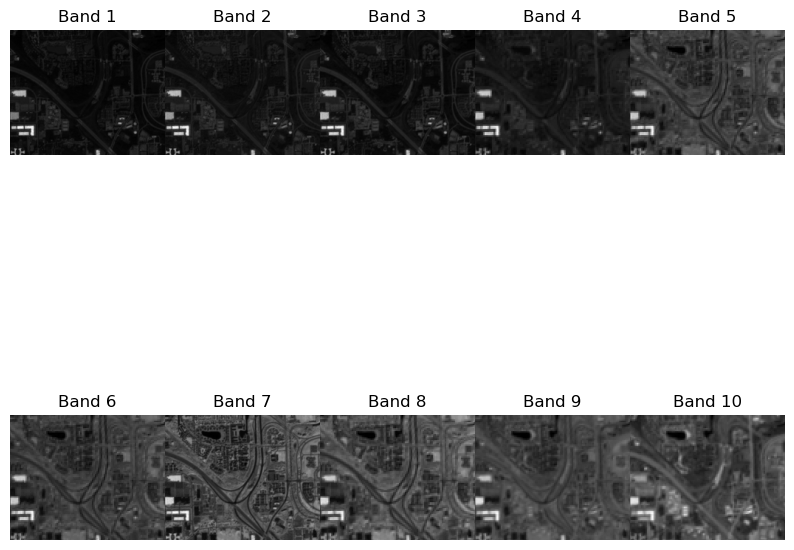

In [16]:
# 5 columns and 2 rows
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 10))
for i in range(10):
    ax[i//5, i%5].imshow(ds.GetRasterBand(i+1).ReadAsArray(), cmap='gray')
    ax[i//5, i%5].set_title('Band ' + str(i+1))
    ax[i//5, i%5].axis('off')
    # reduce white space between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

In [11]:
#  read bands as array
array=ds.ReadAsArray()
print("Array Shape:",array.shape)
# Array Shape: (10, 170, 210): means 10 bands, 170 rows and 210 columns

Array Shape: (10, 170, 210)


In [12]:
# stack array into one array
array_stack=np.stack(array,axis=2) # axis=2 means stack along third dimension
print("Array Stack Shape:",array_stack.shape)
#Array Stack Shape: (170, 210, 10): means 170 rows, 210 columns and 10 bands

Array Stack Shape: (170, 210, 10)


In [13]:
# reshape array to 10 columns, and 35700 rows
array_reshape=array_stack.reshape(array_stack.shape[0]*array_stack.shape[1],array_stack.shape[2])
print("Array Reshape Shape:",array_reshape.shape)
# Array Reshape Shape: (35700, 10): we have convert 3d array to 2d array

Array Reshape Shape: (35700, 10)


In [14]:
# convert array to dataframe
df_array=pd.DataFrame(array_reshape,dtype='int16')
print("Dataframe Shape:",df_array.shape)
print("Dataframe Head:")
df_array.head(2)

Dataframe Shape: (35700, 10)
Dataframe Head:


,0,1,2,3,4,5,6,7,8,9
0,1673,1734,1568,999,1033,1033,1694,1226,1440,1413
1,920,668,768,549,503,503,732,681,809,862


# Random Forest Classifier

In [23]:
# import random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,random_state=0)

In [25]:
# train classifier and fit it to data
clf.fit(df_B,labels)
# predict labels
pred_rf=clf.predict(df_array)
classification=pred_rf.reshape(rows,cols)

C:\Users\Hafez\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# support vector machine classifier

In [80]:

from sklearn.svm import SVC
clf_svm=SVC(kernel='rbf',random_state=0)
clf_svm.fit(df_B,labels)

SVC(random_state=0)

# multi layer perceptron classifier

In [16]:

from sklearn.neural_network import MLPClassifier
clf_mlp=MLPClassifier(random_state=0)
clf_mlp.fit(df_B,labels)

MLPClassifier(random_state=0)

In [89]:
#predict class fro multilayer perceptron classifier
pred_mlp=clf_mlp.predict(df_array)

C:\Users\Hafez\miniconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [81]:
# predict class from clf_svm
pred_svm=clf_svm.predict(df_array)

C:\Users\Hafez\miniconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [17]:
# predict classes
pred_rf=clf.predict(df_array)

C:\Users\Hafez\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [18]:
#print shape of pred
print("Pred Shape:",pred_rf.shape)

Pred Shape: (35700,)


In [70]:
array_stack.shape[0],array_stack.shape[1],rows,cols

(170, 210, 170, 210)

In [39]:
classification=pred_rf.reshape(rows,cols)
print("Classification Shape:",classification.shape)

Classification Shape: (170, 210)


In [20]:
print("Classification Shape:",classification.shape)

Classification Shape: (170, 210)


In [40]:
#unique of classification
print("Unique:",np.unique(classification))

Unique: [1 2 3 4 5]


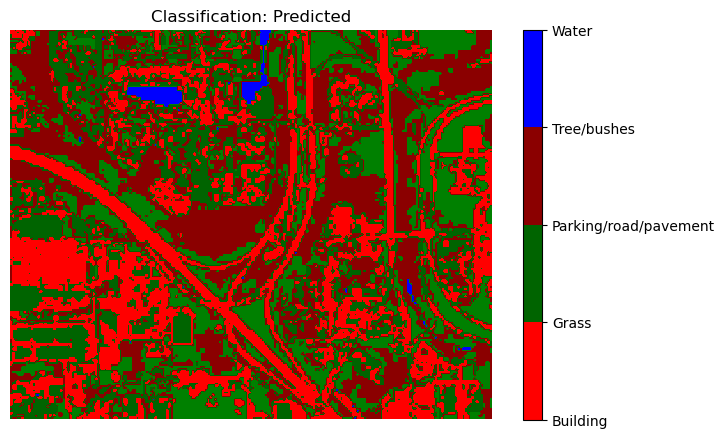

In [41]:
classes=np.unique(classification)
num_colors = 5 
cm = plt.get_cmap('jet') 
scheme = [cm(i*1./num_colors) for i in range(num_colors)] 
bins = np.linspace(0, 5, num_colors)  
color_class={1:'red',2:'darkgreen',3:'darkred',4:'green',5:'blue'}
# create color map
cmap=ListedColormap(color_class.values())
# define  each color class
color_labeling=np.array(np.unique(df['Landuse']))# ['Building' 'Grass' 'Parking/road/pavement' 'Tree/bushes' 'Water']
len_color_labeling=len(color_labeling)
# now plot each color class
fig,ax=plt.subplots(figsize=(8,5))
cax=ax.imshow(classification,cmap=cmap)
# set title
ax.set_title('Classification: Predicted')
# off axis
ax.set_axis_off()
# add color bar with water,forest,grassland,building,barren
cbar=fig.colorbar(cax,ticks=bins, boundaries=bins,orientation='vertical')
cbar.ax.set_yticklabels(color_labeling)
# decrease space between plot and color bar
plt.subplots_adjust(bottom=0.1)
plt.show()

# Save classified image

In [87]:
def creategeotiff(Imap,gt,proj,filename):
    # create a new geotiff file
    driver=gdal.GetDriverByName("GTiff")
    dataset=driver.Create(filename,cols,rows,1,gdal.GDT_Int32)
    # set the geotransform
    dataset.SetGeoTransform(gt)
    # set the projection
    dataset.SetProjection(proj)
    # write the array to the geotiff
    dataset.GetRasterBand(1).WriteArray(Imap)
    dataset=None
creategeotiff(classification,gt,projection,'classification_rf.tif')

# Deep learning Model- Tensorflow/Keras

In [18]:
# kappa metric
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score
from tensorflow import keras
# define optimizer: stochastic gradient descent
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

# make  tensorflow model for classification: df_B,labels


In [71]:
#grid_point=pd.read_csv('E:/R/basic/Data_RS_DNN/Data_RS_DNN/Sentinel_2/grid_data.csv')
LU_ID=pd.read_csv('E:/R/basic/Data_RS_DNN/Data_RS_DNN/Sentinel_2/Landuse_ID_keras.csv')
print("LU_ID:")
LU_ID.head(2)

LU_ID:


,Class_ID,Class,Description
0,0,Class_1,Parking/road/pavement
1,1,Class_2,Building


In [72]:
# select columns containin B
Class_ID=df[['Class_ID']]
#X=dataset[dataset.columns[dataset.columns.str.contains('B')]]
X = df[['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']]
# flatten the class id
Y=np.ravel(Class_ID)
print("Y:",Y.shape)

Y: (23945,)


In [73]:
# Split the data up in train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
# unique of Y_train
print("Unique Y Train:",np.unique(Y_train))
# scale train and test data
X_train=preprocessing.scale(X_train)
X_test=preprocessing.scale(X_test)
X_train.shape[1]
# model development and define vars
input_num_units=X_train.shape[1]
print("Input Num Units:",input_num_units)
hidden1_num_units=200
hidden2_num_units=200
hidden3_num_units=200
hidden4_num_units=200
output_num_units=5 # print("Unique Y Train:",np.unique(Y_train))

Unique Y Train: [1 2 3 4 5]
Input Num Units: 10


In this case, the neural network has four hidden layers, each with 200 neurons, and an output layer with 5 neurons, corresponding to the 5 classes in the classification problem.

In [77]:
# Define the model architecture
model = tf.keras.Sequential([
    # First hidden layer with ReLU activation and L2 regularization
    tf.keras.layers.Dense(units=hidden1_num_units, input_shape=(input_num_units,), activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2), # Dropout layer to prevent overfitting
    # Second hidden layer with ReLU activation and L2 regularization
    tf.keras.layers.Dense(units=hidden1_num_units, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2), # Dropout layer to prevent overfitting
    # Third hidden layer with ReLU activation and L2 regularization
    tf.keras.layers.Dense(units=hidden1_num_units, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.1), # Dropout layer to prevent overfitting
    # Fourth hidden layer with ReLU activation and L2 regularization
    tf.keras.layers.Dense(units=hidden1_num_units, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.1), # Dropout layer to prevent overfitting
    # Output layer with softmax activation because we have a multi-class classification problem
    tf.keras.layers.Dense(units=hidden1_num_units, activation='softmax')
])
# Print a summary of the model architecture
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 200)               2200      
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 200)              

In [32]:
# Save a visualization of the model architecture as a PNG image
plot_model(model, to_file='model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Epoch 1/10
1916/1916 - 9s - loss: 0.4272 - accuracy: 0.8854
Epoch 2/10
1916/1916 - 7s - loss: 0.2684 - accuracy: 0.9254
Epoch 3/10
1916/1916 - 7s - loss: 0.2385 - accuracy: 0.9355
Epoch 4/10
1916/1916 - 7s - loss: 0.2177 - accuracy: 0.9418
Epoch 5/10
1916/1916 - 9s - loss: 0.2094 - accuracy: 0.9460
Epoch 6/10
1916/1916 - 10s - loss: 0.1893 - accuracy: 0.9513
Epoch 7/10
1916/1916 - 8s - loss: 0.1829 - accuracy: 0.9548
Epoch 8/10
1916/1916 - 7s - loss: 0.1758 - accuracy: 0.9572
Epoch 9/10
1916/1916 - 7s - loss: 0.1698 - accuracy: 0.9588
Epoch 10/10
1916/1916 - 7s - loss: 0.1637 - accuracy: 0.9615
dict_keys(['loss', 'accuracy'])
48/48 [==============================] - 1s 6ms/step - loss: 0.1450 - accuracy: 0.9747
[0.14502950012683868, 0.9747337698936462]
Baseline Error: 2.53%
Test Classes: [3 2 2 ... 2 1 4]
Y_test: [3 2 2 ... 2 1 4]
              precision    recall  f1-score   support

           1       0.95      0.98      0.97      1102
           2       0.98      0.95      0.96     

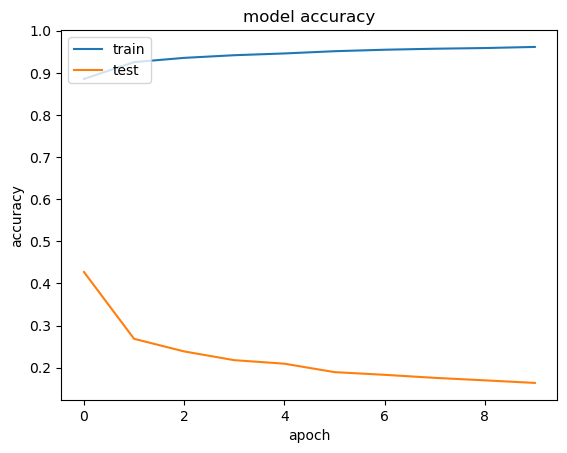

In [78]:
sgd=SGD(learning_rate=0.01,decay=1e-6,momentum=0.9,nesterov=True)
# model compile
model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
# fit model: epochs=10, batch_size=10 means that the model will be trained on 10 samples at a time for 10 epochs
history=model.fit(X_train,Y_train,epochs=10,batch_size=10,verbose=2)
# suumarise history of accuracy
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('apoch')
plt.legend(['train','test'],loc='upper left')

# Model evaluation with test data set 
# Prediction at test data set
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test,batch_size=100, verbose=1)
print(score)
print("Baseline Error: %.2f%%" % (100-score[1]*100))
# class prediction
test_classes = np.argmax(model.predict(X_test), axis=-1)
print("Test Classes:",test_classes)
# type of Y_test
print("Y_test:",Y_test)
# classification report
print(classification_report(Y_test,test_classes))
# confusion matrix
print(confusion_matrix(Y_test,test_classes))

The accuracy epoch figure shows how the accuracy of the model changes over the course of training. The x-axis represents the number of epochs (i.e., the number of times the model has been trained on the entire dataset), and the y-axis represents the accuracy of the model on the training set and test set.

The blue line represents the accuracy of the model on the training set, and the orange line represents the accuracy of the model on the test set. If the model is performing well, both lines should increase as the number of epochs increases. However, if the blue line increases but the orange line doesn't, it may indicate that the model is overfitting to the training data and not generalizing well to the test data.

Ideally, we want to see both the training and test accuracy increasing at a similar rate, as this indicates that the model is learning to generalize to new data. If the training accuracy is significantly higher than the test accuracy, it may indicate that the model is overfitting to the training data and not generalizing well. If the test accuracy is significantly higher than the training accuracy, it may indicate that the model is underfitting and not learning enough from the training data.

In [79]:
# accuracy in percentage
accuracy = accuracy_score(Y_test,test_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# accuracy in percentage for each class
print(accuracy_score(Y_test,test_classes,normalize=False))
print("Kappa:",cohen_kappa_score(Y_test,test_classes))

Accuracy: 97.47%
4668
Kappa: 0.9665320580835872


In [80]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test,batch_size=100, verbose=1)
print(score)
print("Baseline Error: %.2f%%" % (100-score[1]*100))

# class preidction
test_classes = np.argmax(model.predict(X_test), axis=-1)
print("Test Classes:",test_classes)
# type of Y_test
print("Y_test:",Y_test)

# classification report
print(classification_report(Y_test,test_classes))

# confusion matrix
print(confusion_matrix(Y_test,test_classes))
# accuracy in percentage
accuracy = accuracy_score(Y_test,test_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# accuracy in percentage for each class
print(accuracy_score(Y_test,test_classes,normalize=False))
# kappa metric
from sklearn.metrics import cohen_kappa_score
print("Kappa:",cohen_kappa_score(Y_test,test_classes))

48/48 [==============================] - 0s 3ms/step - loss: 0.1450 - accuracy: 0.9747
[0.14502950012683868, 0.9747337698936462]
Baseline Error: 2.53%
Test Classes: [3 2 2 ... 2 1 4]
Y_test: [3 2 2 ... 2 1 4]
              precision    recall  f1-score   support

           1       0.95      0.98      0.97      1102
           2       0.98      0.95      0.96       879
           3       0.97      0.98      0.98      1618
           4       1.00      0.97      0.98       971
           5       1.00      0.97      0.99       219

    accuracy                           0.97      4789
   macro avg       0.98      0.97      0.98      4789
weighted avg       0.98      0.97      0.97      4789

[[1084   16    2    0    0]
 [  33  836   10    0    0]
 [  22    2 1592    2    0]
 [   0    0   28  943    0]
 [   0    0    6    0  213]]
Accuracy: 97.47%
4668
Kappa: 0.9665320580835872


In [81]:
grid_point=pd.read_csv('E:/R/basic/Data_RS_DNN/Data_RS_DNN/Sentinel_2/prediction_grid_data.csv')
# Create grid data frame with ten bands
X_grid = grid_point[['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']]
#Prediction at Grid Locations
xygrid=grid_point[['ID','x','y']]
X_grid=grid_point[['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']]
#scale grid
X_grid_scaled=preprocessing.scale(X_grid)
# Prediction at grid locations
grid_class = pd.DataFrame(np.argmax(model.predict(X_grid_scaled), axis=-1))
# unique values 
print("Unique Values:",np.unique(grid_class))
grid_class.head(2)

Unique Values: [1 2 3 4 5]


,0
0,2
1,5


In [82]:
# Join xy-coordinates with predicted grid_class data frame
grid_class_xy = pd.concat([xygrid,grid_class],axis=1)
grid_class_xy.head(2)

,ID,x,y,0
0,1,677775,4764065,2
1,2,677785,4764065,5


In [83]:
# rename column 3rd column: Class_ID_pred: predicted
grid_class_xy.rename(columns={0:'Class_ID'},inplace=True)
# change columns 
grid_class_xy

,ID,x,y,Class_ID
0,1,677775,4764065,2
1,2,677785,4764065,5
2,3,677795,4764065,2
3,4,677805,4764065,1
4,5,677815,4764065,1
...,...,...,...,...
35695,35696,679825,4762375,4
35696,35697,679835,4762375,4
35697,35698,679845,4762375,4
35698,35699,679855,4762375,3


In [84]:
# unique class id
grid_class_xy.Class_ID.unique()

array([2, 5, 1, 3, 4], dtype=int64)

In [85]:
## Load landuse ID file
LU_ID = pd.read_csv("E:/R/basic/Data_RS_DNN/Data_RS_DNN/Sentinel_2/Landuse_ID.csv")
LU_ID

,Class_ID,Class,Landuse
0,1,Class_1,Parking/road/pavement
1,2,Class_2,Building
2,3,Class_3,Tree/bushes
3,4,Class_4,Grass
4,5,Class_5,Water


In [92]:
# make dictionary of landuse id and landuse name 
LU_ID_dict = dict(zip(LU_ID.Class_ID,LU_ID.Landuse))
# now replace class id with landuse name: with new column:Class_ID_d
grid_class_xy['Class_ID_d'] = grid_class_xy['Class_ID'].map(LU_ID_dict)
grid_class_xy.head(2)

,ID,x,y,Class_ID,Class_ID_d,geometry
0,1,677775,4764065,2,Building,POINT (677775.000 4764065.000)
1,2,677785,4764065,5,Water,POINT (677785.000 4764065.000)


In [126]:
# join LU_ID with grid_class_xy
grid_class_xy_LU=pd.merge(grid_class_xy,LU_ID,on='Class_ID',how='left')
# define geometry 
geometry = [Point(xy) for xy in zip(grid_class_xy.x, grid_class_xy.y)]
# set projection utm 17N: 26917 meters
# create GeoDataFrame
grid_class_final_gdf = gpd.GeoDataFrame(grid_class_xy, crs='EPSG:26917', geometry=geometry)
grid_class_final_gdf.head(3)

,ID,x,y,Class_ID,Class_ID_d,geometry
0,1,677775,4764065,2,Building,POINT (677775.000 4764065.000)
1,2,677785,4764065,5,Water,POINT (677785.000 4764065.000)
2,3,677795,4764065,2,Building,POINT (677795.000 4764065.000)


<AxesSubplot:>

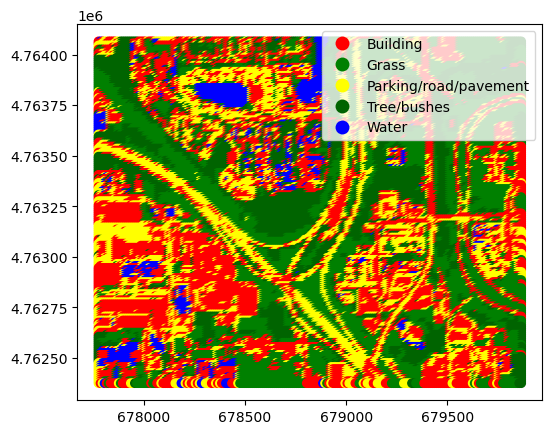

In [125]:
# red =Building,green=Grass,yellow=Parking/road/pavement, darkgreen=Tree,blue=Water
colors=['red','green','yellow','darkgreen','blue']
# make plot of description: Class_ID_d:red,green, yellow,darkgreen,blue
grid_class_final_gdf.plot(column='Class_ID_d',legend=True,figsize=(6, 6),cmap=ListedColormap(colors))

In [118]:
# check geometry type valid or not
grid_class_final_gdf.geometry.is_valid.all()

True

In [120]:
grid_class_final_gdf = grid_class_final_gdf.to_crs(epsg=26917)

In [123]:
grid_class_final_gdf['geometry'].area

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
35695    0.0
35696    0.0
35697    0.0
35698    0.0
35699    0.0
Length: 35700, dtype: float64

In [121]:
# dissolve by Class_ID_d
grid_class_final_gdf_dissolve=grid_class_final_gdf.dissolve(by='Class_ID_d')
# area calculation in sq km
grid_class_final_gdf_dissolve['geometry'].area

Class_ID_d
Building                 0.0
Grass                    0.0
Parking/road/pavement    0.0
Tree/bushes              0.0
Water                    0.0
dtype: float64

In [124]:
# Check for invalid geometries
invalid_geom = grid_class_final_gdf_dissolve[~grid_class_final_gdf_dissolve.is_valid]

# Buffer invalid geometries by a very small distance
buffered_geom = invalid_geom.buffer(0)

# Replace the invalid geometries with the buffered geometries
grid_class_final_gdf_dissolve.loc[~grid_class_final_gdf_dissolve.is_valid, 'geometry'] = buffered_geom

# Recalculate the area
grid_class_final_gdf_dissolve['geometry'].area


Class_ID_d
Building                 0.0
Grass                    0.0
Parking/road/pavement    0.0
Tree/bushes              0.0
Water                    0.0
dtype: float64